# 實驗一：房價預測模型

### Import必要套件

In [4]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
tf.test.is_gpu_available()



False

### 數據讀取並分析

In [5]:
data = pd.read_csv("kc_house_data.csv")
# 顯示dataset的形狀，共21613比資料，每一比資料有21種不同資訊。
data.shape

(21613, 21)

In [20]:
# 將顯示列數設定為25，不然會有部份資料無法顯示
pd.options.display.max_columns = 25
# head 會顯示前五行的數據
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


各個數據的簡寫分別代表下面意思：
- date：房屋出售日期。
- price：房屋價格（目標）。
- bedrooms：臥室數量。
- bathrooms：浴室數量。
- sqft_living：居住的坪數（平方英尺）。
- sqft_lot：實際的坪數（平方英尺）。
- floors：房屋總共樓層。
- waterfront：海景房。
- view：房屋是否看過。
- condition：整體條件有多好。
- grade：房屋的整體等級（根據King County評分系統）。
- sqft_above：除了地下室外的坪數（平方英尺）。
- sqft_basement：地下室的坪數（平方英尺）。
- yr_built：房屋建造時間。
- yr_renovated：何時重新裝修過（一些沒重新裝修過或是裝修紀錄沒被記錄到的數值都為0）。
- zipcode：郵政編碼。
- lat：緯度座標。
- long：經度座標。
- sqft_living15：2015年紀錄的居住坪數（可能是翻新的原因導致sqft_living15與sqft_living不同）。
- sqft_lot15：2015年紀錄的實際坪數（可能是翻新的原因導致sqft_lot15與sqft_lot不同）。

### 檢查資料的型態

資料型態總共有五種：object(string),booleab, integer, float and categorical.

In [21]:
data.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 數據前處理
轉換資料型態：
因為數據集裡的date數據是字串（string）格式，而模型的輸入只接受數值格式，所以可以透過以下程式碼將其轉為數值，並分成年、月及日三種數據。

In [22]:
# 將date日期拆為年、月和日並轉成數值
data['year'] = pd.to_numeric(data['date'].str.slice(0, 4))
data['month'] = pd.to_numeric(data['date'].str.slice(4, 6))
data['day'] = pd.to_numeric(data['date'].str.slice(6, 8))

# 刪除沒有用的數據，inplace則是將更新後的資料存回原本的地方
data.drop(['id'], axis="columns", inplace=True)
data.drop(['date'], axis="columns", inplace=True)

data.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,10,13
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,12,9
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,2,25
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,12,9
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,2,18


分割數據集（Dataset）：將數據集切割成三個部份，訓練數據（Training data）、驗證數據（Validation data）和測試數據（Testing data）。

In [23]:
data_num = data.shape[0]
# 取得一筆與data數量相同的亂數索引，主要目的是用於打散資料
indexes = np.random.permutation(data_num)
# 並將亂數索引值分為Train、validation和test分為，這裡的劃分比例為6:2:2
train_indexes = indexes[:int(data_num *0.6)]
val_indexes = indexes[int(data_num *0.6):int(data_num *0.8)]
test_indexes = indexes[int(data_num *0.8):]
# 透過索引值從data取出訓練資料、驗證資料和測試資料
train_data = data.loc[train_indexes]
val_data = data.loc[val_indexes]
test_data = data.loc[test_indexes]

### Normalization 正規化

使用標準分數(Standard Score, 又稱z-score)將數據正規化，經過z-score正規化後數據的都會聚集在0附近， 標準差為1。 

(x - 平均值) / 標準差

In [24]:
train_validation_data = pd.concat([train_data, val_data])
mean = train_validation_data.mean()
std = train_validation_data.std()

train_data = (train_data - mean) / std
val_data = (val_data - mean) / std

### 建立Numpy array格式的訓練數據

In [25]:
x_train = np.array(train_data.drop('price', axis='columns'))
y_train = np.array(train_data['price'])
x_val = np.array(val_data.drop('price', axis='columns'))
y_val = np.array(val_data['price'])

整理過後的資料共12967筆，且一筆資料有21種資訊(所以網路輸入必須為21)。

In [26]:
x_train.shape

(12967, 21)

### 建立並訓練網路模型

這裡建構三層全連接層的網路架構，並且使用ReLU作為隱藏層的激活函數，而由於需得到線性輸出，故輸出層不使用任何激活函數。

In [27]:
# 建立一個Sequential型態的model
model = keras.Sequential(name='model-1')
# 第1層全連接層設為64個unit，將輸入形狀設定為(21, )，而實際上我們輸入的數據形狀為(batch_size, 21)
model.add(layers.Dense(64, activation='relu', input_shape=(21,)))
# 第2層全連接層設為64個unit
model.add(layers.Dense(64, activation='relu'))
# 最後一層全連接層設為1個unit
model.add(layers.Dense(1))
# 顯示網路模型架構
model.summary()

Model: "model-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 64)                1408      
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,633
Trainable params: 5,633
Non-trainable params: 0
_________________________________________________________________


設定訓練使用的優化器、損失函數和指標函數：

In [28]:
model.compile(keras.optimizers.Adam(0.001),
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

創建模型儲存目錄：

In [29]:
model_dir = 'lab2-logs/models/'
try:
    os.makedirs(model_dir)
    
except:
    pass

設定回調函數：

In [30]:
# TensorBoard回調函數會幫忙紀錄訓練資訊，並存成TensorBoard的紀錄檔
log_dir = os.path.join('lab2-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
# ModelCheckpoint回調函數幫忙儲存網路模型，可以設定只儲存最好的模型，「monitor」表示被監測的數據，「mode」min則代表監測數據越小越好。
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                        monitor='val_mean_absolute_error', 
                                        save_best_only=True, 
                                        mode='min')

訓練網路模型：

In [31]:
history = model.fit(x_train, y_train,  # 傳入訓練數據
               batch_size=64,  # 批次大小設為64
               epochs=300,  # 整個dataset訓練300遍
               validation_data=(x_val, y_val),  # 驗證數據
               callbacks=[model_cbk, model_mckp])  # Tensorboard回調函數紀錄訓練過程，ModelCheckpoint回調函數儲存最好的模型

Epoch 1/300
203/203 [==============================] - 1s 2ms/step - loss: 0.3549 - mean_absolute_error: 0.3615 - val_loss: 0.2454 - val_mean_absolute_error: 0.2935
Epoch 2/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2077 - mean_absolute_error: 0.2867 - val_loss: 0.2055 - val_mean_absolute_error: 0.2714
Epoch 3/300
203/203 [==============================] - 0s 2ms/step - loss: 0.1803 - mean_absolute_error: 0.2690 - val_loss: 0.2061 - val_mean_absolute_error: 0.2711
Epoch 4/300
203/203 [==============================] - 0s 2ms/step - loss: 0.1633 - mean_absolute_error: 0.2548 - val_loss: 0.1830 - val_mean_absolute_error: 0.2559
Epoch 5/300
203/203 [==============================] - 0s 2ms/step - loss: 0.1481 - mean_absolute_error: 0.2436 - val_loss: 0.1685 - val_mean_absolute_error: 0.2407
Epoch 6/300
203/203 [==============================] - 0s 2ms/step - loss: 0.1360 - mean_absolute_error: 0.2316 - val_loss: 0.1706 - val_mean_absolute_error: 0.2464
Epoch 7/30

### 訓練結果

In [32]:
history.history.keys()  # 查看history儲存的資訊有哪些

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

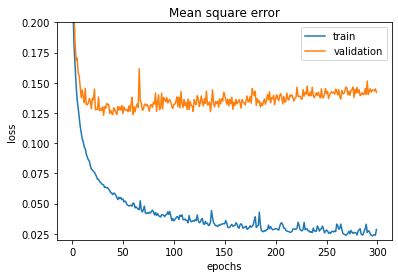

In [33]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylim(0.02, 0.2)
plt.title('Mean square error')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')

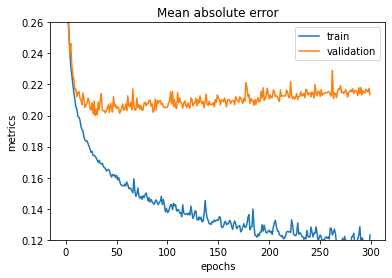

In [34]:
plt.plot(history.history['mean_absolute_error'], label='train')
plt.plot(history.history['val_mean_absolute_error'], label='validation')
plt.ylim(0.12, 0.26)
plt.title('Mean absolute error')
plt.ylabel('metrics')
plt.xlabel('epochs')
plt.legend(loc='upper right')

測試數據的誤差百分比：用測試數據預測房屋價格並與答案計算誤差百分比。

In [35]:
# 載入模型
model = keras.models.load_model('lab2-logs/models/Best-model-1.h5')
# 先將房屋價格取出
y_test = np.array(test_data['price'])
# 標準化數據
test_data = (test_data - mean) / std
# 將輸入數據存成Numpy 格式
x_test = np.array(test_data.drop('price', axis='columns'))
# 預測測試數據
y_pred = model.predict(x_test)
# 將預測結果轉換回來(因為訓練時的訓練目標也有經過標準化)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
# 計算平均的誤差百分比
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
# 顯示誤差百分比
print("Model_1 Percentage Error: {:.2f}%".format(percentage_error))

136/136 [==============================] - 0s 904us/step
Model_1 Percentage Error: 13.92%


### TensorBoard 可視化工具

In [50]:
# 這行指令可以幫助我們直接在jupyter notebook上顯示TensorBoard
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
%tensorboard --port 9530 --logdir lab2-logs

Reusing TensorBoard on port 9530 (pid 21888), started 0:33:31 ago. (Use '!kill 21888' to kill it.)

# 實驗二：過擬合問題

### 方法一、減少網路權重

In [38]:
model_2 = keras.Sequential(name='model-2')
model_2.add(layers.Dense(16, activation='relu', input_shape=(21,)))
model_2.add(layers.Dense(16, activation='relu'))
model_2.add(layers.Dense(1))

model_2.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_2.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 3ms/step - loss: 0.5727 - mean_absolute_error: 0.4529 - val_loss: 0.3484 - val_mean_absolute_error: 0.3663
Epoch 2/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2974 - mean_absolute_error: 0.3386 - val_loss: 0.2690 - val_mean_absolute_error: 0.3250
Epoch 3/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2460 - mean_absolute_error: 0.3124 - val_loss: 0.2429 - val_mean_absolute_error: 0.3001
Epoch 4/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2236 - mean_absolute_error: 0.2954 - val_loss: 0.2294 - val_mean_absolute_error: 0.2908
Epoch 5/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2082 - mean_absolute_error: 0.2866 - val_loss: 0.2154 - val_mean_absolute_error: 0.2871
Epoch 6/300
203/203 [==============================] - 0s 2ms/step - loss: 0.1967 - mean_absolute_error: 0.2775 - val_loss: 0.2085 - val_mean_absolute_error: 0.2770
Epoch 7/30

### 加入L1或L2 正則化

In [39]:
model_3 = keras.Sequential(name='model-3')
model_3.add(layers.Dense(64, 
                         kernel_regularizer=keras.regularizers.l2(0.001), 
                         activation='relu', input_shape=(21,)))
model_3.add(layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))
model_3.add(layers.Dense(1))

model_3.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-3')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-3.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_3.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 3ms/step - loss: 0.4295 - mean_absolute_error: 0.3663 - val_loss: 0.3293 - val_mean_absolute_error: 0.3068
Epoch 2/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2947 - mean_absolute_error: 0.2890 - val_loss: 0.2888 - val_mean_absolute_error: 0.2801
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: 0.2600 - mean_absolute_error: 0.2690 - val_loss: 0.2660 - val_mean_absolute_error: 0.2633
Epoch 4/300
203/203 [==============================] - 1s 2ms/step - loss: 0.2374 - mean_absolute_error: 0.2550 - val_loss: 0.2518 - val_mean_absolute_error: 0.2606
Epoch 5/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2222 - mean_absolute_error: 0.2473 - val_loss: 0.2368 - val_mean_absolute_error: 0.2419
Epoch 6/300
203/203 [==============================] - 0s 2ms/step - loss: 0.2065 - mean_absolute_error: 0.2353 - val_loss: 0.2235 - val_mean_absolute_error: 0.2358
Epoch 7/30

### 加入 Dropout

In [40]:
model_4 = keras.Sequential(name='model-4')
model_4.add(layers.Dense(64, activation='relu', input_shape=(21,)))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(64, activation='relu'))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Dense(1))

model_4.compile(keras.optimizers.Adam(0.001),
                loss=keras.losses.MeanSquaredError(),
                metrics=[keras.metrics.MeanAbsoluteError()])

log_dir = os.path.join('lab2-logs', 'model-4')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-4.h5', 
                                             monitor='val_mean_absolute_error', 
                                             save_best_only=True, 
                                             mode='min')
model_4.fit(x_train, y_train, 
            batch_size=64 ,
            epochs=300, 
            validation_data=(x_val, y_val), 
            callbacks=[model_cbk, model_mckp])

Epoch 1/300
203/203 [==============================] - 1s 3ms/step - loss: 0.5460 - mean_absolute_error: 0.4750 - val_loss: 0.2939 - val_mean_absolute_error: 0.3224
Epoch 2/300
203/203 [==============================] - 0s 2ms/step - loss: 0.3503 - mean_absolute_error: 0.3747 - val_loss: 0.2502 - val_mean_absolute_error: 0.3031
Epoch 3/300
203/203 [==============================] - 1s 3ms/step - loss: 0.3092 - mean_absolute_error: 0.3471 - val_loss: 0.2509 - val_mean_absolute_error: 0.3033
Epoch 4/300
203/203 [==============================] - 1s 3ms/step - loss: 0.2714 - mean_absolute_error: 0.3274 - val_loss: 0.2449 - val_mean_absolute_error: 0.3010
Epoch 5/300
203/203 [==============================] - 1s 3ms/step - loss: 0.2635 - mean_absolute_error: 0.3189 - val_loss: 0.2156 - val_mean_absolute_error: 0.2847
Epoch 6/300
203/203 [==============================] - 1s 3ms/step - loss: 0.2379 - mean_absolute_error: 0.3053 - val_loss: 0.2064 - val_mean_absolute_error: 0.2826
Epoch 7/30

### 驗證正則化的效能

Test model 2:

In [45]:
model_2 = keras.models.load_model('lab2-logs/models/Best-model-2.h5')
y_pred = model_2.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_2: {:.2f}%".format(percentage_error))

136/136 [==============================] - 0s 1ms/step
Model_2: 13.62%


Test model 3:

In [46]:
model_3 = keras.models.load_model('lab2-logs/models/Best-model-3.h5')
y_pred = model_3.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_3: {:.2f}%".format(percentage_error))

136/136 [==============================] - 0s 1ms/step
Model_3: 13.08%


Test model 4:

In [47]:
model_4 = keras.models.load_model('lab2-logs/models/Best-model-4.h5')
y_pred = model_4.predict(x_test)
y_pred = np.reshape(y_pred * std['price'] + mean['price'], y_test.shape)
percentage_error = np.mean(np.abs(y_test - y_pred)) / np.mean(y_test) * 100
print("Model_4: {:.2f}%".format(percentage_error))

136/136 [==============================] - 0s 1ms/step
Model_4: 13.87%


In [44]:
# %load_ext tensorboard
# %tensorboard --logdir lab2-logs
